In [2]:
library(dplyr)
library(lme4)
library(nlme)
library(purrr)
library(performance)
library(tibble)
library(MuMIn)
library(here)
library(reactablefmtr)
library(emmeans)
library(car)
library(ggplot2)
library(modelr)
require(vegan)
require(knitr)
require(ggpubr)
library(ggeffects)
library(janitor)
library(sjPlot)
library(factoextra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘nlme’


The following object is masked from ‘package:lme4’:

    lmList


The following object is masked from ‘package:dplyr’:

    collapse


here() starts at /home/ecamo19/Documents/projects/nutrients_and_water_effects_2022/shade_house_reproducible_stats

Loading required package: reactable

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘ggplot2’


The following object is masked from ‘package:reactablefmtr’:

    margin



Attaching package: ‘modelr’


The following objects are masked from ‘package:performance’:

    mae, mse, rmse


Loading required package: vegan



In [1]:
setwd(here::here())

In [3]:
# Load all joined dataset
source("./scripts/code_join_data_full_dataset.R")


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [4]:
# Load custom made functions
source("./R/functions_models.R")
source("./R/function_plots.R")
source("./R/function_validation_plots.R")
source("./R/function_for_inference_emmeans_and_percentage_diff.R")


In [5]:
# set plot dimensions
options(repr.plot.width = 15)
options(repr.plot.height = 10)

__For running each peice of code press shift + Enter__

# __Q3:How do functional traits, treatment, and N-fixing status interact to influence seedling-level growth rates and biomass accumulation?__


## PCA


In [12]:
# Select variables that are going to be used in the model
data_for_models <-
    data_for_models %>%

    clean_names() %>%
    # Select columns needed for regression
    dplyr::select(spcode, treatment, nfixer, init_height,

                  # Performance measures
                  total_biomass, rgr, root_shoot_ratio,

                  # physiology traits
                  amax, gs, wue,pnue,

                  # Leaf traits
                  narea_g_m2, d13c) %>%
    clean_names()

In [13]:
# Center and scale by 2 as Gelman et al 2008

data_traits_scaled <-
    data_for_models %>%
        select(-c(total_biomass, rgr, root_shoot_ratio, init_height)) %>%
        mutate(across(where(is.numeric), scale))

In [14]:
pca_traits <- princomp(data_traits_scaled[,c(4:ncol(data_traits_scaled))])

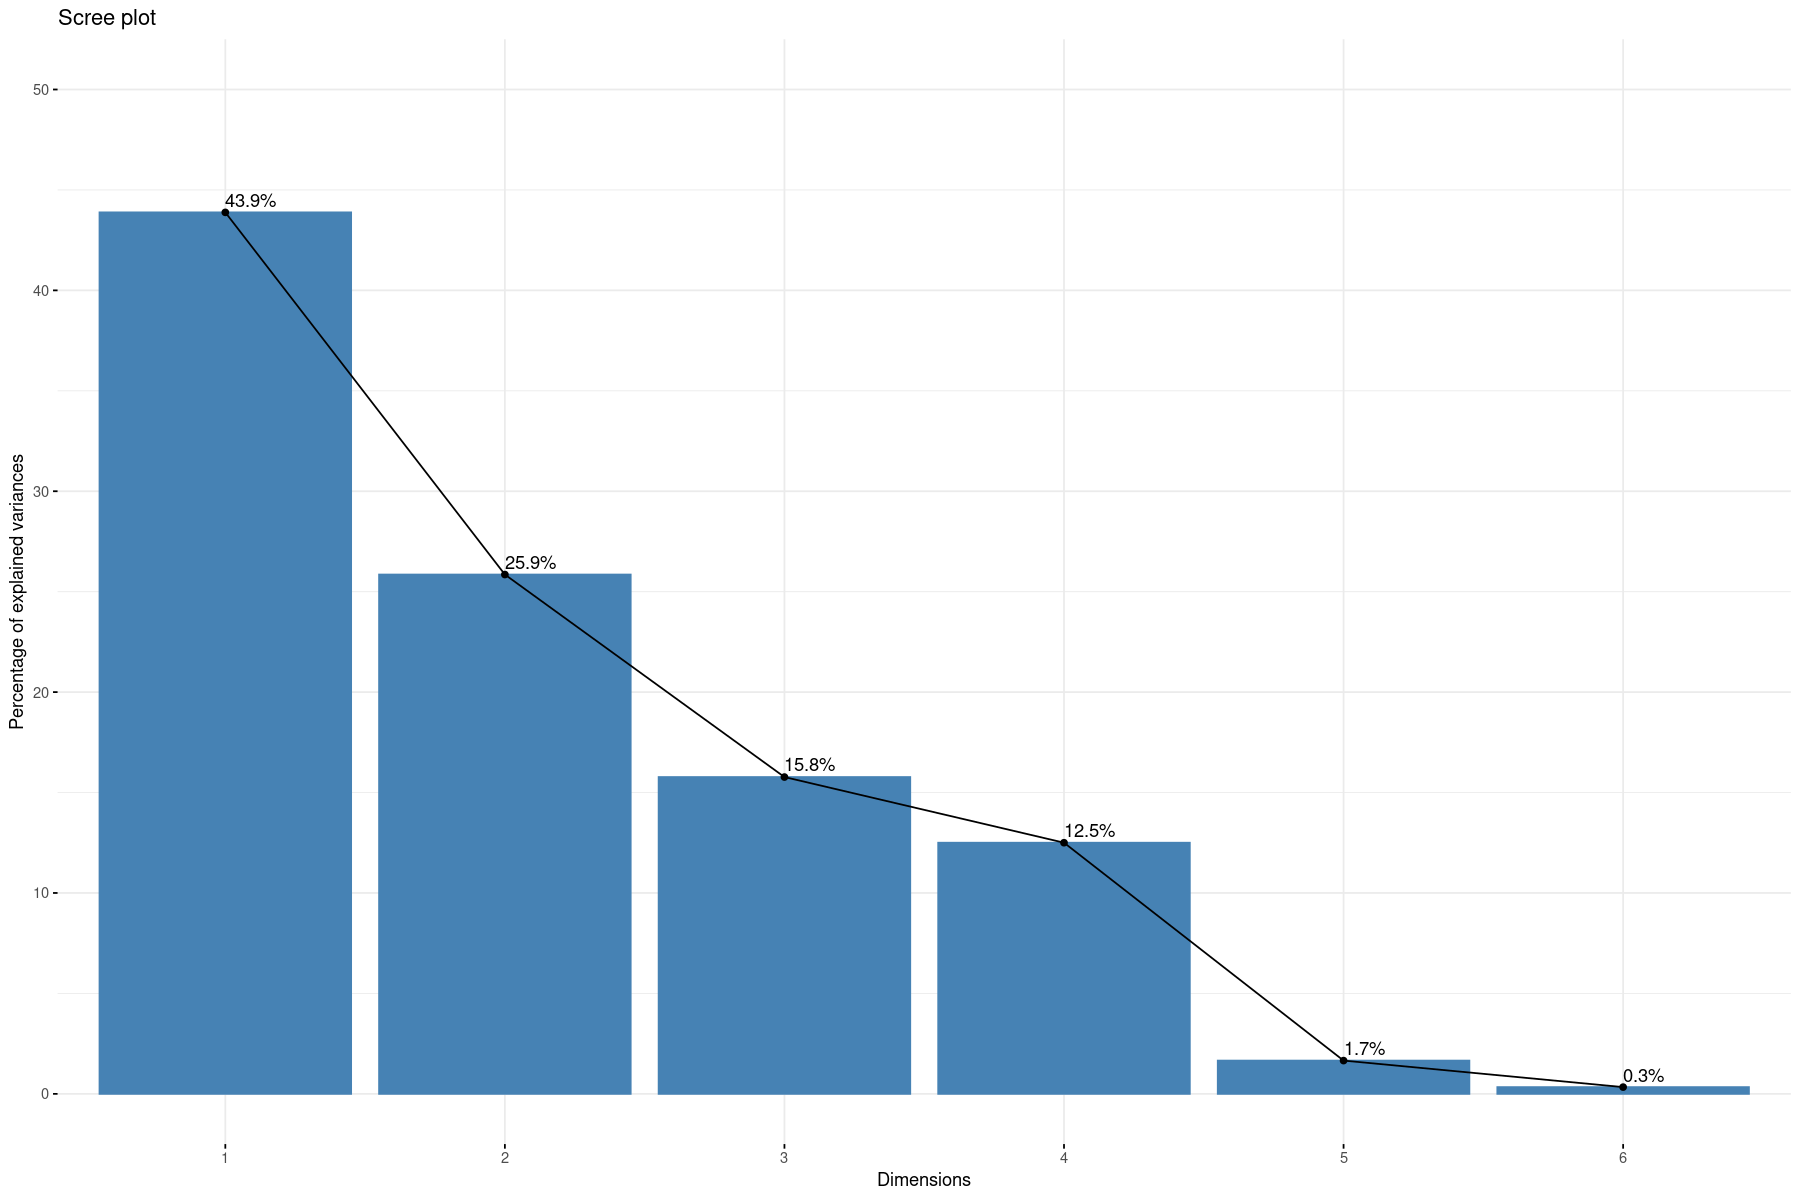

In [15]:
fviz_screeplot(pca_traits, addlabels = TRUE, ylim = c(0, 50))

In [16]:
# Extract loadings
pca_traits$loadings


Loadings:
           Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
amax        0.607                       0.325  0.718
gs          0.233  0.610  0.505  0.107 -0.554       
wue         0.454 -0.335 -0.488 -0.141 -0.649       
pnue        0.287  0.534 -0.323 -0.553  0.312 -0.353
narea_g_m2  0.518 -0.224  0.211  0.459  0.261 -0.598
d13c        0.141 -0.422  0.598 -0.666              

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.167  0.167  0.167  0.167  0.167  0.167
Cumulative Var  0.167  0.333  0.500  0.667  0.833  1.000

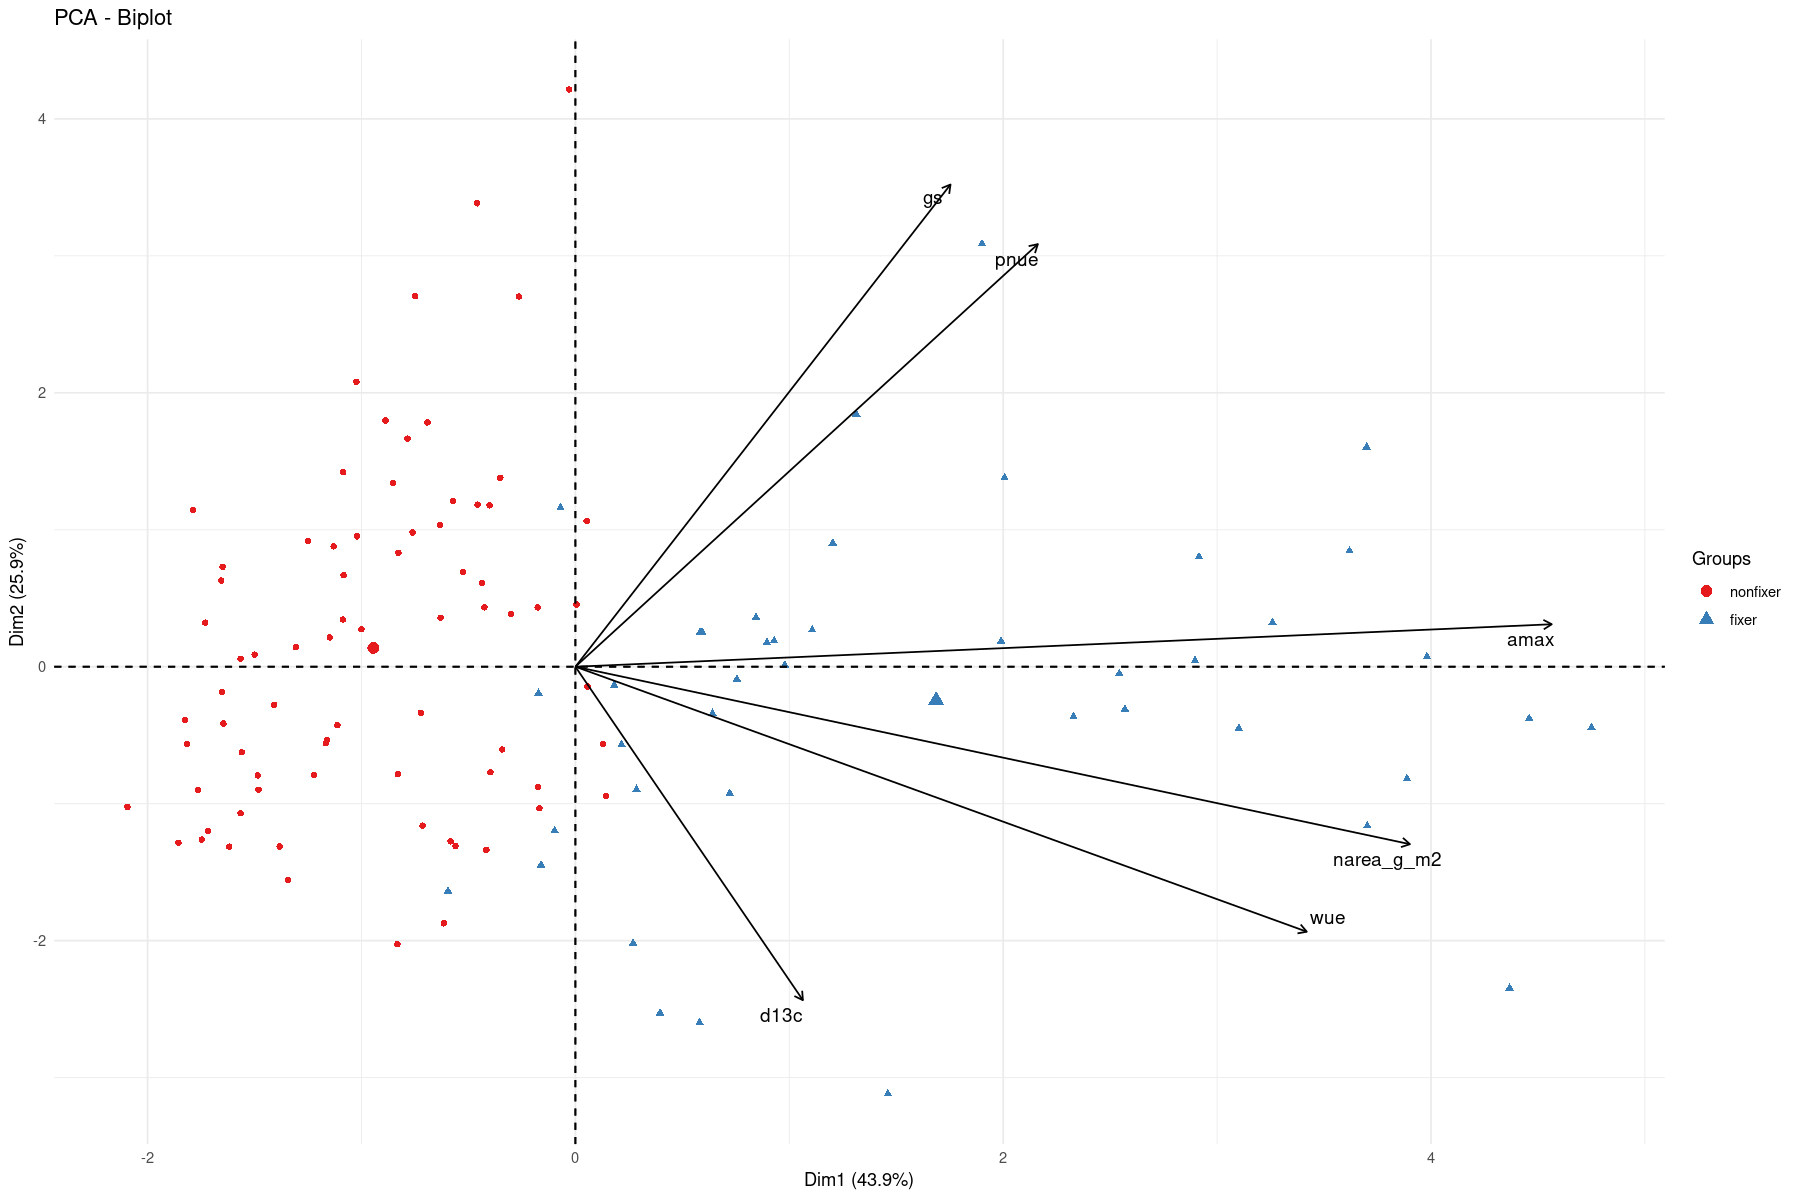

In [17]:
fviz_pca_biplot(pca_traits,axes = c(1, 2),

                # Add group
                habillage= data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

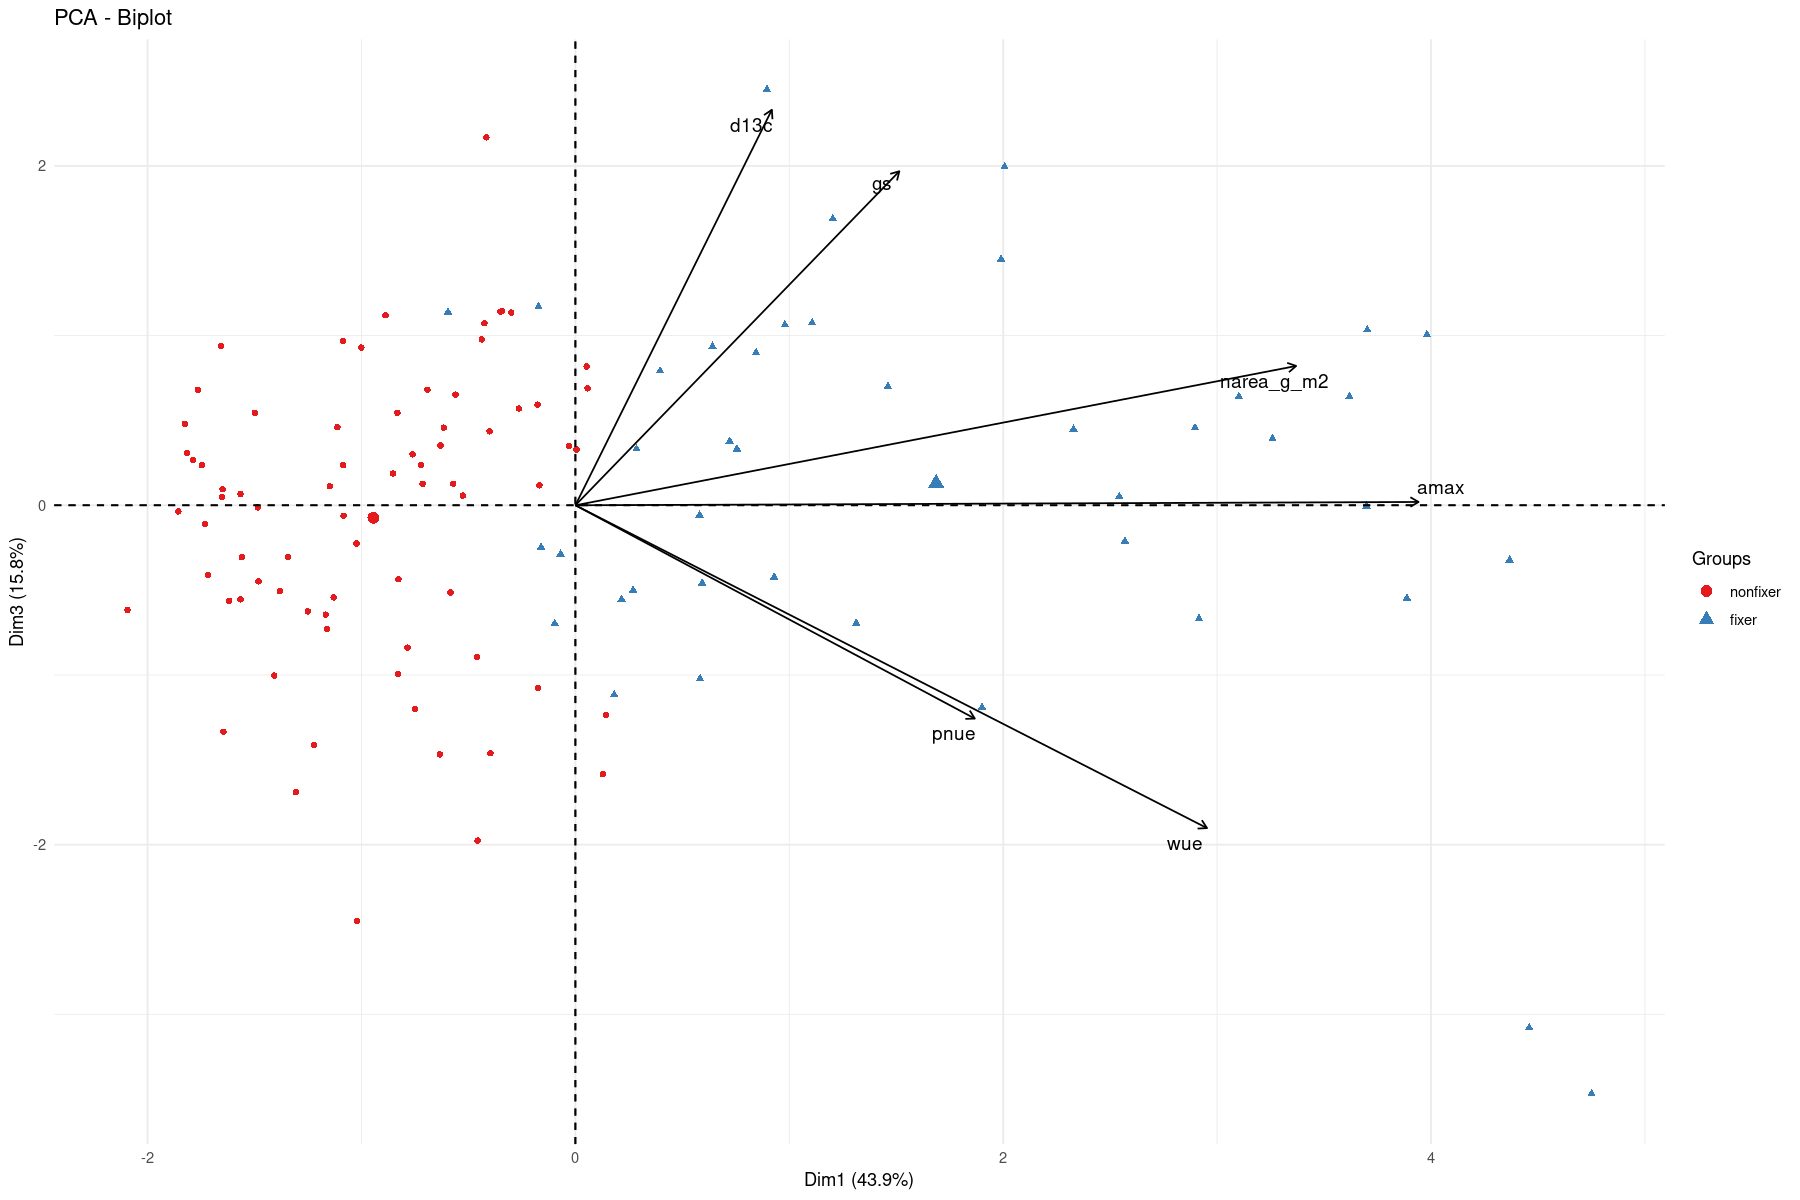

In [21]:
fviz_pca_biplot(pca_traits,axes = c(1, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

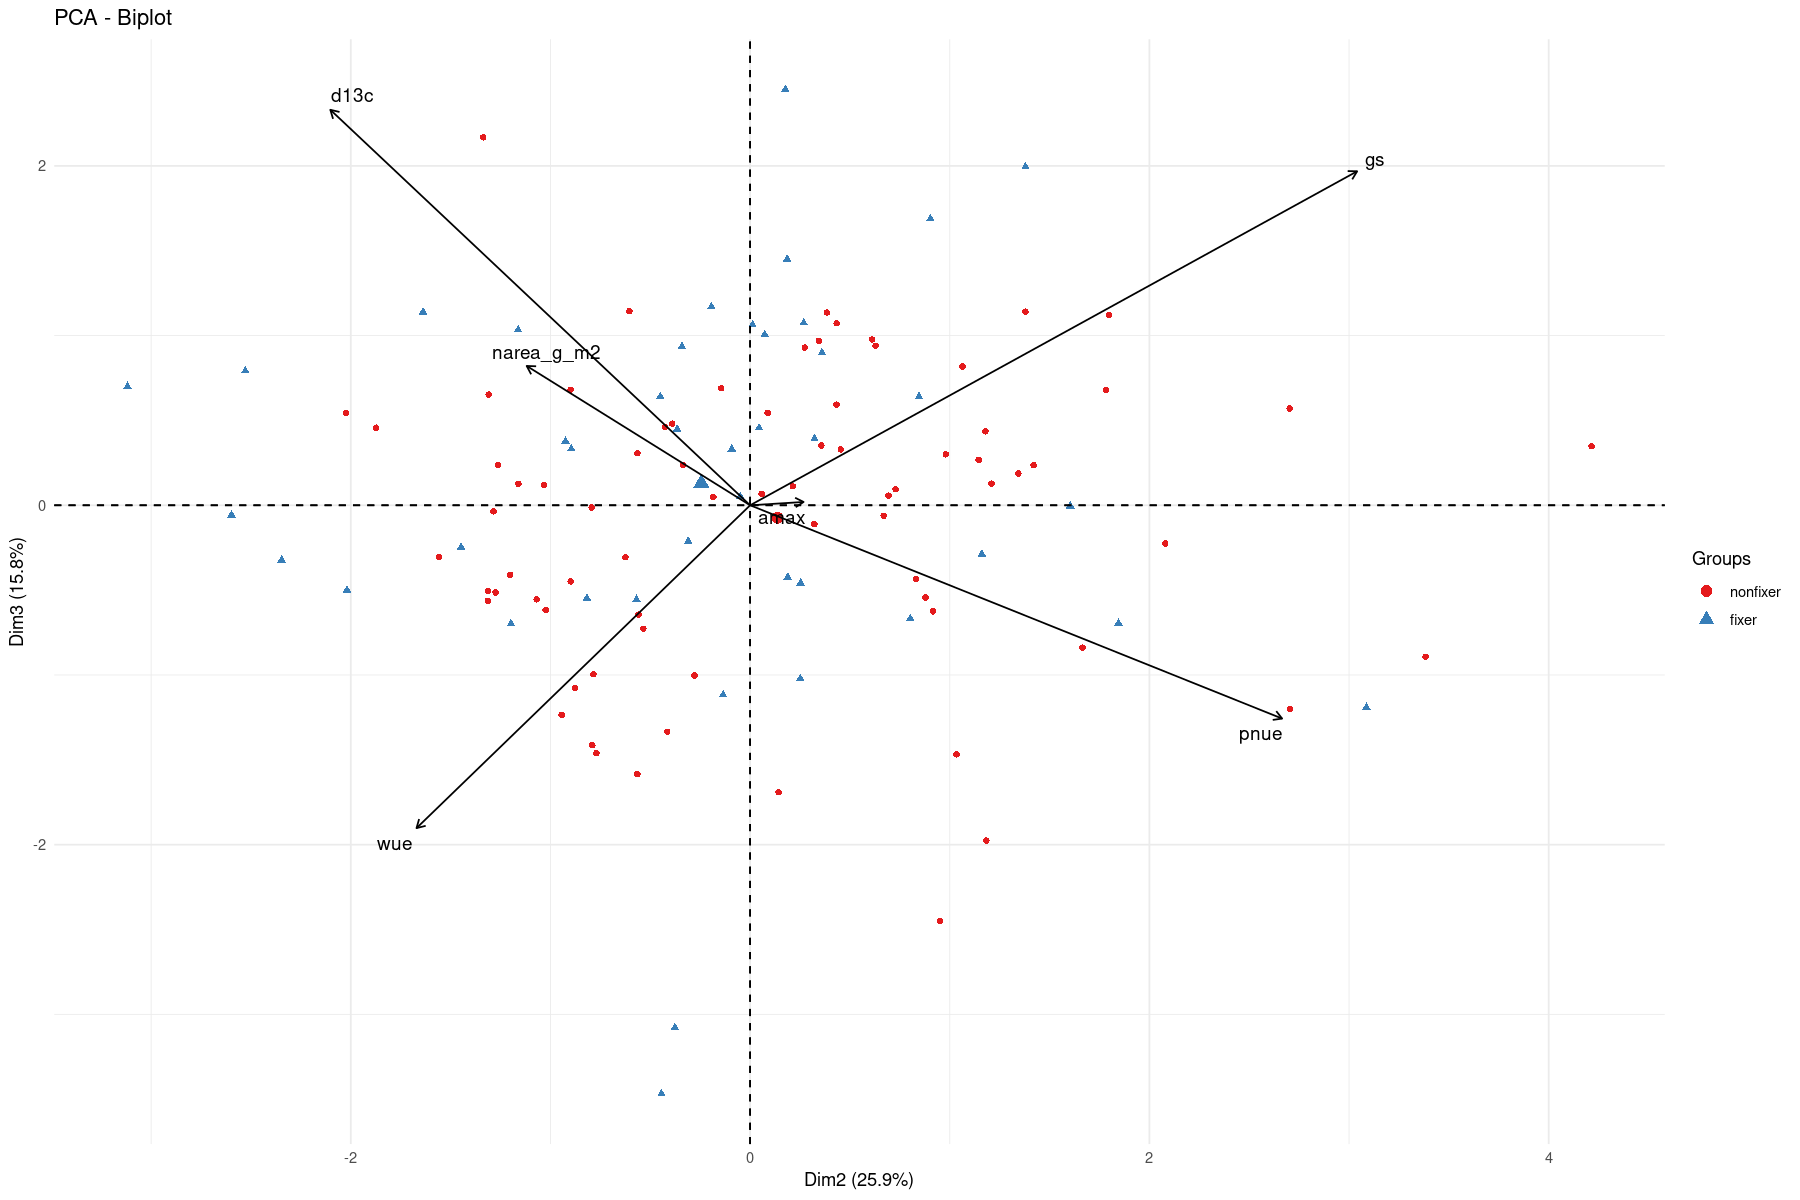

In [19]:
fviz_pca_biplot(pca_traits,axes = c(2, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

## Biplots interpretation
[PCA interpretation](https://wilkelab.org/SDS375/slides/dimension-reduction-1.html#18)

+ The first 3 PCs explains 81% (47.9,19.4,15.8) of the variability in the data
+ PC1 separates fixers from non-fixers
+ All traits contribute positively to PC1 

+ PC1 represents the overall high photosynthetic capacity 
+ PC2 represents the difference between stomatal conductance and 
+ PC3 represents the difference between d13c and 

## Regression models 

$$response\sim treatment*fixer*PCn\ + initial\ height\ + random(1|specie)$$

In [22]:
pca_scores <- scores(pca_traits)

In [23]:
data_performance <-

    data_for_models %>%
        select(-c(amax, gs,wue, narea_g_m2,	d13c, pnue))

In [24]:
data_for_regression_scaled_traits <-
    inner_join(data_performance, data_traits_scaled, , by = c("treatment","spcode", "nfixer"))


Warning message in inner_join(data_performance, data_traits_scaled, , by = c("treatment", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [25]:
# add t-ratio
emm_options(contrast = list(infer = c(TRUE, TRUE)))

### Total biomass

In [26]:
model_pc_total_biomass <- lmer(total_biomass ~  treatment * amax +
                                                treatment * gs  +
                                                treatment * d13c +
                                                treatment * pnue +

                                                nfixer * amax +
                                                nfixer * gs  +
                                                nfixer * d13c +
                                                nfixer * pnue +


                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

### Relative Growth Rate

In [27]:
model_pc_rgr <- lmer(rgr ~  treatment * amax +
                            treatment * gs  +
                            treatment * d13c +
                            treatment * pnue +

                            nfixer * amax +
                            nfixer * gs  +
                            nfixer * d13c +
                            nfixer * pnue +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

### Root to shoot ratio

In [28]:
model_pc_root_shoot <- lmer(root_shoot_ratio ~  treatment * amax +
                                                treatment * gs  +
                                                treatment * d13c +
                                                treatment * pnue +

                                                nfixer * amax +
                                                nfixer * gs  +
                                                nfixer * d13c +
                                                nfixer * pnue +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

## Model Assumptions

[1] "No variable specified inthe variables argument"


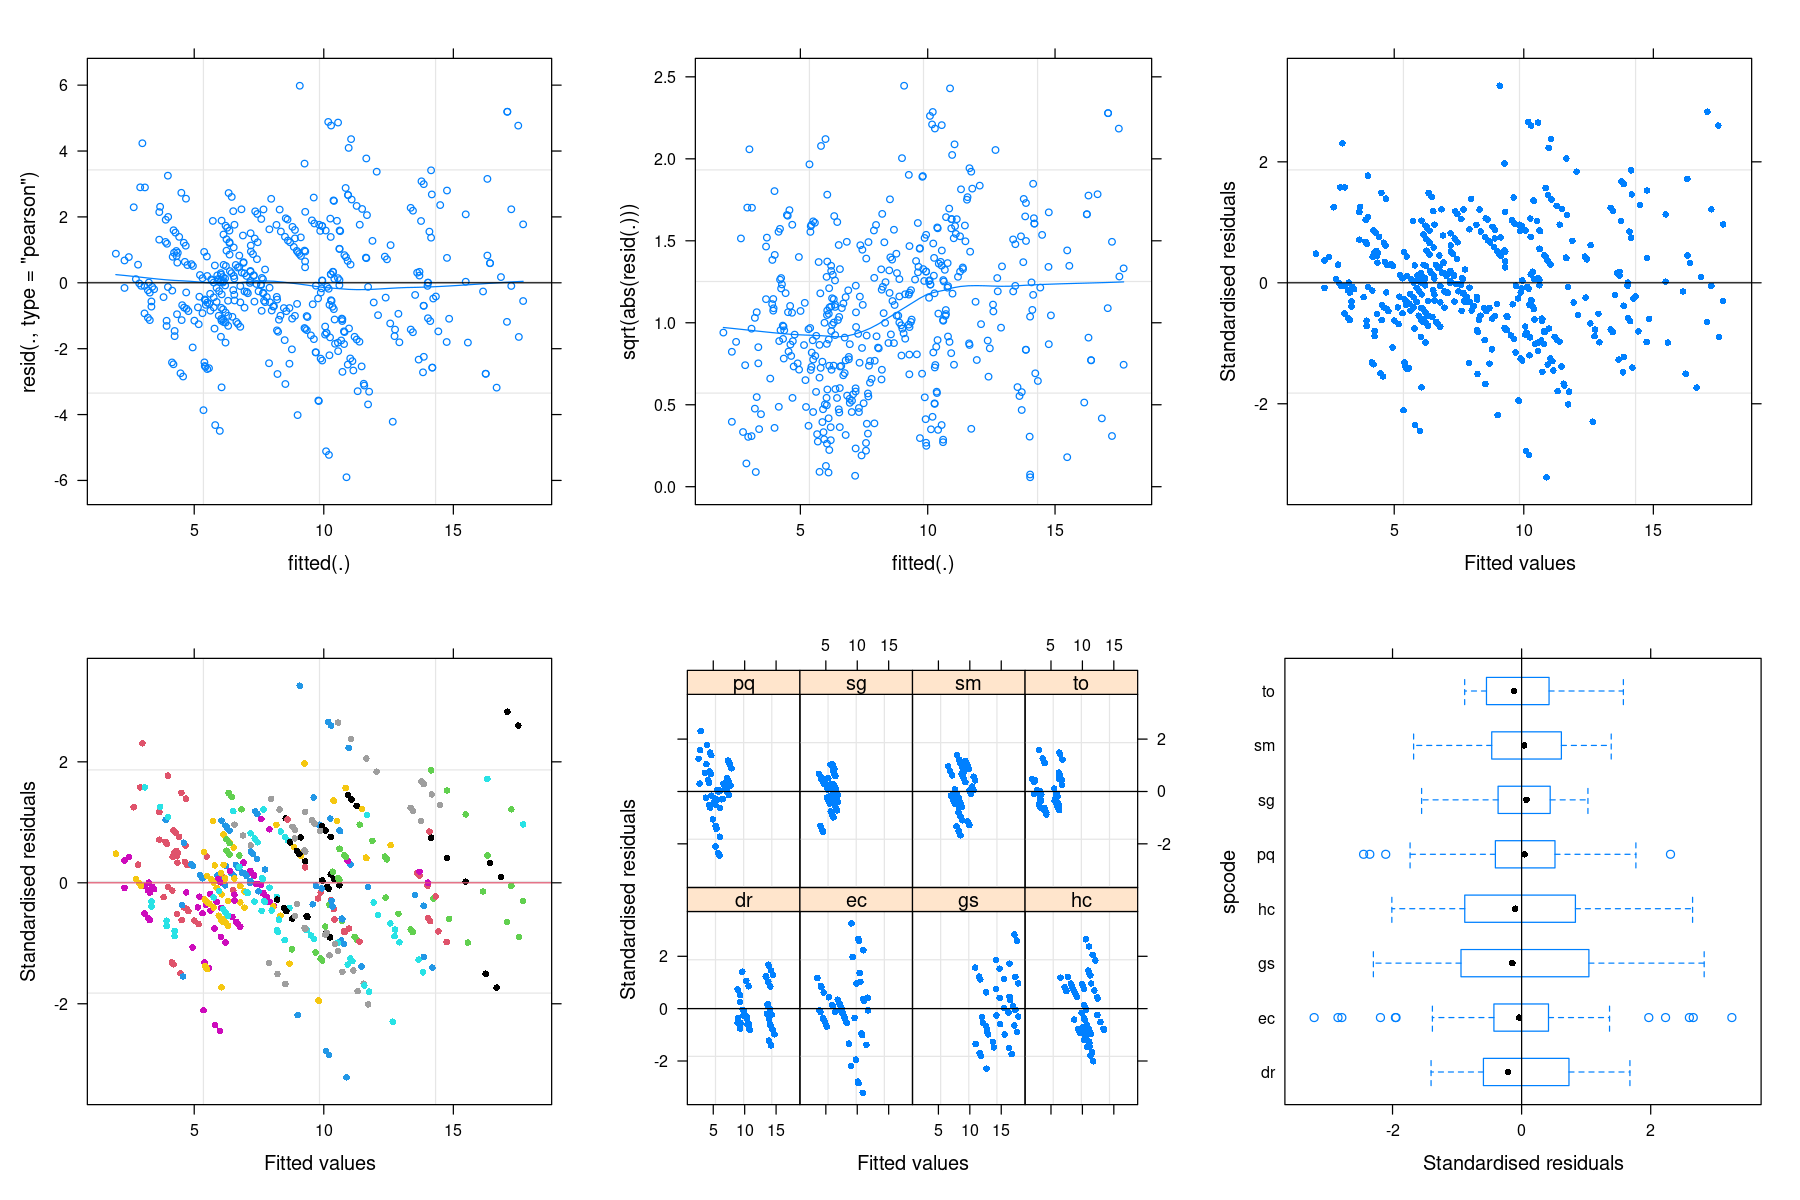

In [29]:
par(mfrow = c(3,3))
validation_plots(model_pc_total_biomass, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


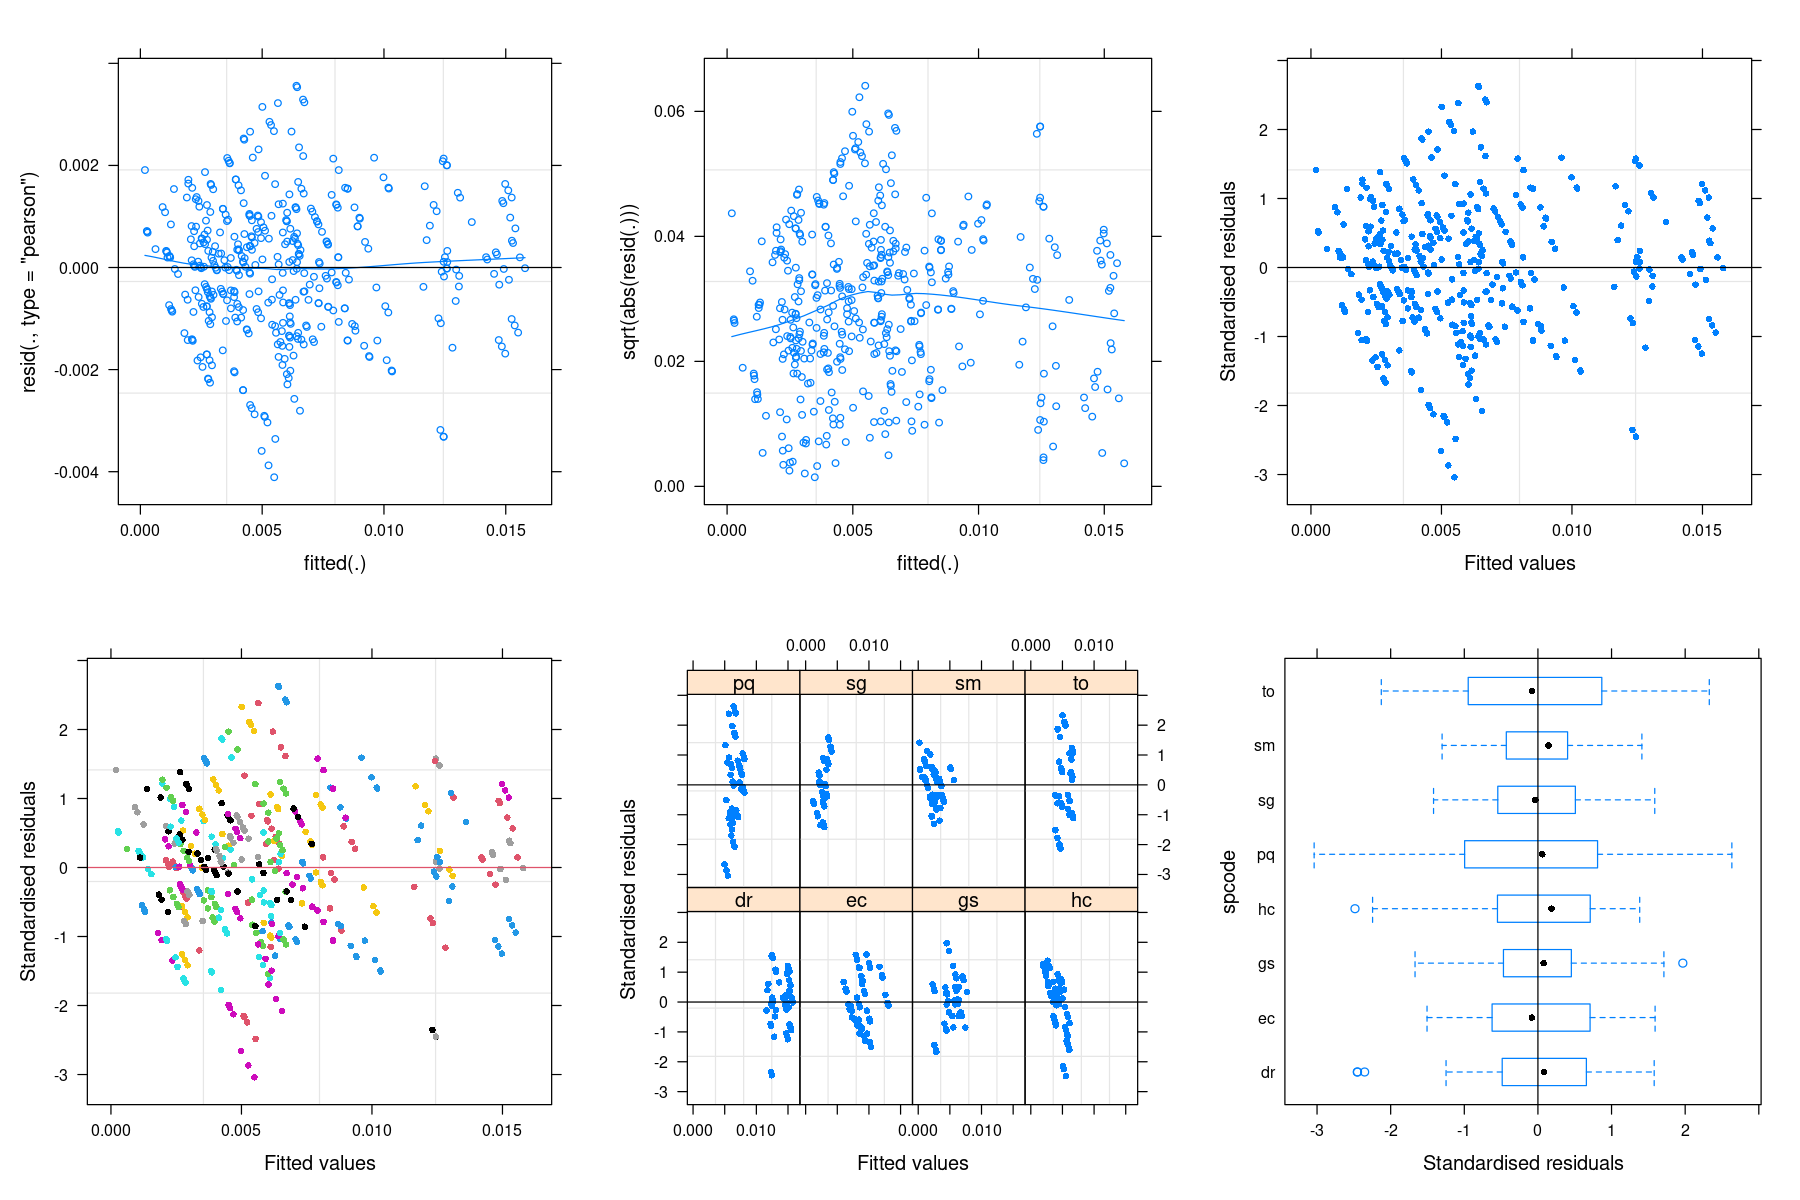

In [30]:
par(mfrow = c(3,3))
validation_plots(model_pc_rgr, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


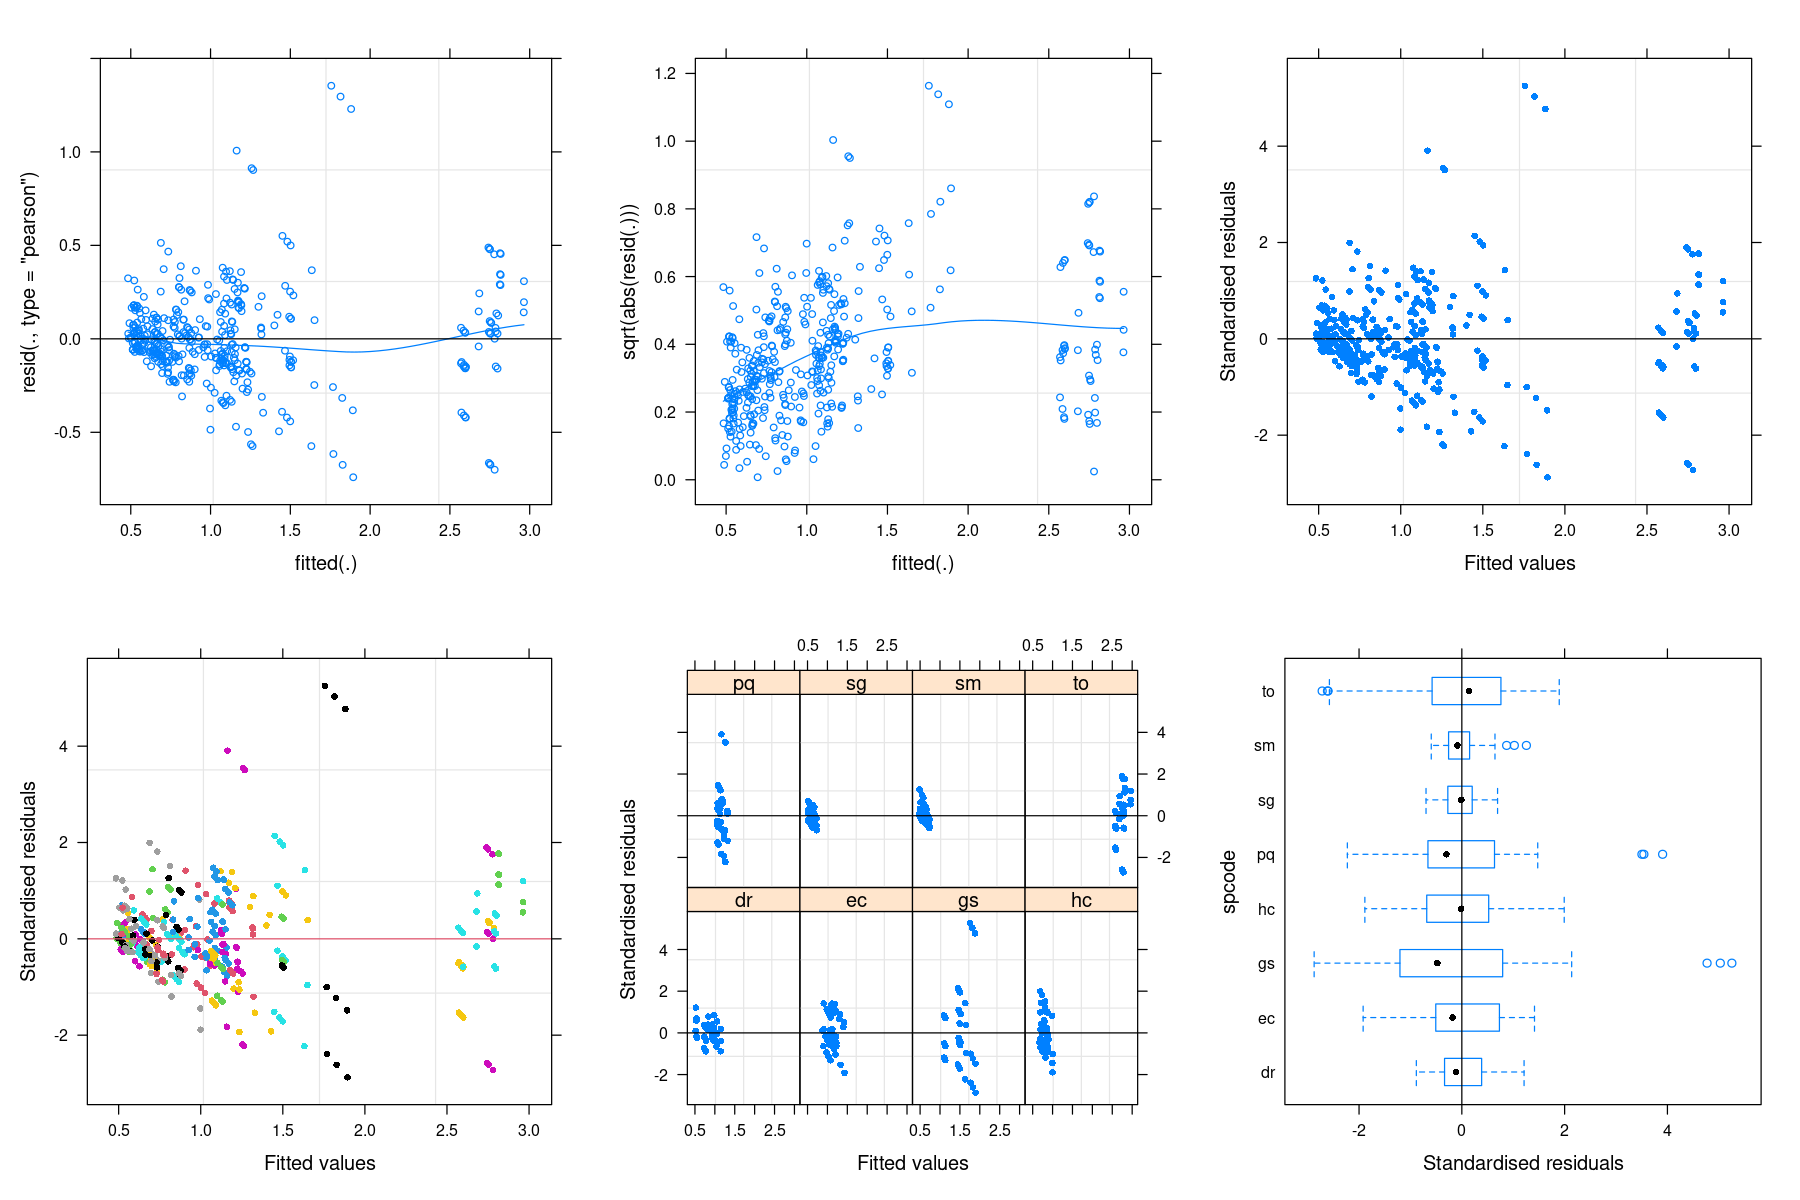

In [31]:
par(mfrow = c(3,3))
validation_plots(model_pc_root_shoot, data = data_for_models,group = "spcode")

## Model inference

In [32]:
## r2 models

r2(model_pc_total_biomass) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8186114|   0.4820424|FALSE    |

In [33]:
r2(model_pc_rgr) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.9175405|    0.478645|FALSE    |

In [34]:
r2(model_pc_root_shoot) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8987459|   0.0311722|FALSE    |

## Anova tables

### Total Biomass

In [35]:
Anova(model_pc_total_biomass, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.1312657,1,10.909862,1.725098e-01
treatment,53.2900056,3,405.760027,4.645690e-29
amax,1.3139291,1,408.965433,2.523547e-01
gs,5.8434464,1,404.879677,1.607613e-02
d13c,0.4970916,1,407.464536,4.811837e-01
pnue,1.7046333,1,407.731375,1.924194e-01
nfixer,4.3470528,1,7.567278,7.255247e-02
init_height,23.9784479,1,336.273299,1.515748e-06
treatment:amax,4.2633015,3,406.753026,5.564837e-03


#### Amax

In [36]:
emtrends(model_pc_total_biomass,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()




|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -2.0211557| 0.6152098| 407.3042| -3.6081926| -0.4341187| -3.2853114| 0.0060706|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             |  0.0030679| 0.3706860| 405.4893| -0.9531966|  0.9593324|  0.0082763| 0.9999998|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.4676931| 0.3609976| 408.8907| -1.3989322|  0.4635461| -1.2955572| 0.5662750|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  2.0242236| 0.6102945| 406.3

#### gs

In [38]:
emtrends(model_pc_total_biomass,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_nutrients)         | -0.1562646| 0.7114349| 404.0429| -1.9915918|  1.6790625| -0.2196471| 0.9962556|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water)             | -2.1121598| 0.5610241| 406.6615| -3.5594252| -0.6648944| -3.7648291| 0.0010933|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water_nutrients)   | -0.7107084| 0.4294096| 405.7995| -1.8184595|  0.3970427| -1.6550829| 0.3490518|
|(gs-0.00451570905042949 plus_nutrients) - (gs-0.00451570905042949 plus_water)           | -1.9558952| 0.6771179| 404.3099| -3.7026881| -0.2091

#### d13c

In [39]:
emtrends(model_pc_total_biomass,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         |  0.6484914| 0.3348718| 406.1335| -0.2153770| 1.5123598|  1.9365364| 0.2144241|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             | -0.1667641| 0.3040985| 406.5306| -0.9512436| 0.6177154| -0.5483884| 0.9469544|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   | -0.1462620| 0.2714407| 405.8893| -0.8464990| 0.5539751| -0.5388358| 0.9494854|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.8152555| 0.3426169| 403.2675| -1.6991301| 

#### PNUE

In [41]:
emtrends(model_pc_total_biomass,
        pairwise ~ pnue*treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                                                                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_nutrients         |  1.3887121| 0.4264495| 406.0571|  0.2886000|  2.4888241|  3.2564517| 0.0066846|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water             |  0.2142012| 0.3331506| 408.4582| -0.6452067|  1.0736091|  0.6429561| 0.9179662|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water_nutrients   | -0.2517321| 0.3552747| 404.4440| -1.1682496|  0.6647855| -0.7085562| 0.8936878|
|pnue0.00179582118045257 plus_nutrients - pnue0.00179582118045257 plus_water           | -1.1745109| 0.4523530| 407.5433| -2.3414287| -0.0075930| -2.5964

In [42]:
library(report)
report(model_pc_total_biomass)

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict total_biomass with treatment (formula: total_biomass ~ treatment *
amax + treatment * gs + treatment * d13c + treatment * pnue + nfixer * amax +
nfixer * gs + nfixer * d13c + nfixer * pnue + init_height). The model included
spcode as random effect (formula: ~1 | spcode). The model's total explanatory
power is substantial (conditional R2 = 0.82) and the part related to the fixed
effects alone (marginal R2) is of 0.48. The model's intercept, corresponding to
treatment = no_additions, is at 1.96 (95% CI [-0.67, 4.60], t(407) = 1.46, p =
0.144). Within this model:

  - The effect of treatment [plus_nutrients] is statistically significant and
positive (beta = 2.92, 95% CI [1.93, 3.91], t(407) = 5.80, p < .001; Std. beta
= 0.74, 95% CI [0.49, 0.99])
  - The effect of treatment [plus_water] is statistically significant and
positive (beta = 1.38, 95% CI [0.63, 2.13], t(407) = 3.63, p < .001; Std. beta
= 0.35, 95% CI [0.16, 0.54])
  - The effect of treatment [plus_water_nutrients] is statistically significant
and positive (beta = 3.99, 95% CI [3.35, 4.63], t(407) = 12.29, p < .001; Std.
beta = 1.01, 95% CI [0.85, 1.17])
  - The effect of amax is statistically non-significant and negative (beta =
-1.08, 95% CI [-2.93, 0.76], t(407) = -1.15, p = 0.250; Std. beta = -0.28, 95%
CI [-0.75, 0.20])
  - The effect of gs is statistically significant and negative (beta = -0.81, 95%
CI [-1.47, -0.15], t(407) = -2.42, p = 0.016; Std. beta = -0.21, 95% CI [-0.37,
-0.04])
  - The effect of d13c is statistically non-significant and positive (beta =
0.15, 95% CI [-0.27, 0.58], t(407) = 0.71, p = 0.480; Std. beta = 0.04, 95% CI
[-0.07, 0.14])
  - The effect of pnue is statistically non-significant and positive (beta =
0.45, 95% CI [-0.23, 1.13], t(407) = 1.31, p = 0.191; Std. beta = 0.12, 95% CI
[-0.06, 0.29])
  - The effect of nfixer [fixer] is statistically significant and positive (beta
= 4.20, 95% CI [0.26, 8.14], t(407) = 2.09, p = 0.037; Std. beta = 1.06, 95% CI
[0.06, 2.06])
  - The effect of init height is statistically significant and positive (beta =
0.17, 95% CI [0.10, 0.23], t(407) = 5.01, p < .001; Std. beta = 0.33, 95% CI
[0.20, 0.46])
  - The interaction effect of amax on treatment [plus_nutrients] is statistically
significant and positive (beta = 2.02, 95% CI [0.81, 3.23], t(407) = 3.29, p =
0.001; Std. beta = 0.52, 95% CI [0.21, 0.83])
  - The interaction effect of amax on treatment [plus_water] is statistically
non-significant and negative (beta = -3.07e-03, 95% CI [-0.73, 0.72], t(407) =
-8.29e-03, p = 0.993; Std. beta = -7.85e-04, 95% CI [-0.19, 0.19])
  - The interaction effect of amax on treatment [plus_water_nutrients] is
statistically non-significant and positive (beta = 0.47, 95% CI [-0.24, 1.17],
t(407) = 1.30, p = 0.194; Std. beta = 0.12, 95% CI [-0.06, 0.30])
  - The interaction effect of gs on treatment [plus_nutrients] is statistically
non-significant and positive (beta = 0.16, 95% CI [-1.24, 1.55], t(407) = 0.22,
p = 0.826; Std. beta = 0.04, 95% CI [-0.31, 0.39])
  - The interaction effect of gs on treatment [plus_water] is statistically
significant and positive (beta = 2.11, 95% CI [1.01, 3.21], t(407) = 3.77, p <
.001; Std. beta = 0.54, 95% CI [0.26, 0.81])
  - The interaction effect of gs on treatment [plus_water_nutrients] is
statistically non-significant and positive (beta = 0.71, 95% CI [-0.13, 1.55],
t(407) = 1.66, p = 0.098; Std. beta = 0.18, 95% CI [-0.03, 0.39])
  - The interaction effect of d13c on treatment [plus_nutrients] is statistically
non-significant and negative (beta = -0.65, 95% CI [-1.31, 8.88e-03], t(407) =
-1.94, p = 0.053; Std. beta = -0.16, 95% CI [-0.32, 2.21e-03])
  - The interaction effect of d13c on treatment [plus_water] is statistically
non-significant and positive (beta = 0.17, 95% CI [-0.43, 0.76], t(407) = 0.55,
p = 0.583; Std. beta = 0.04, 95% CI [-0.11, 0.19])
  - The interaction effect of d13c on t

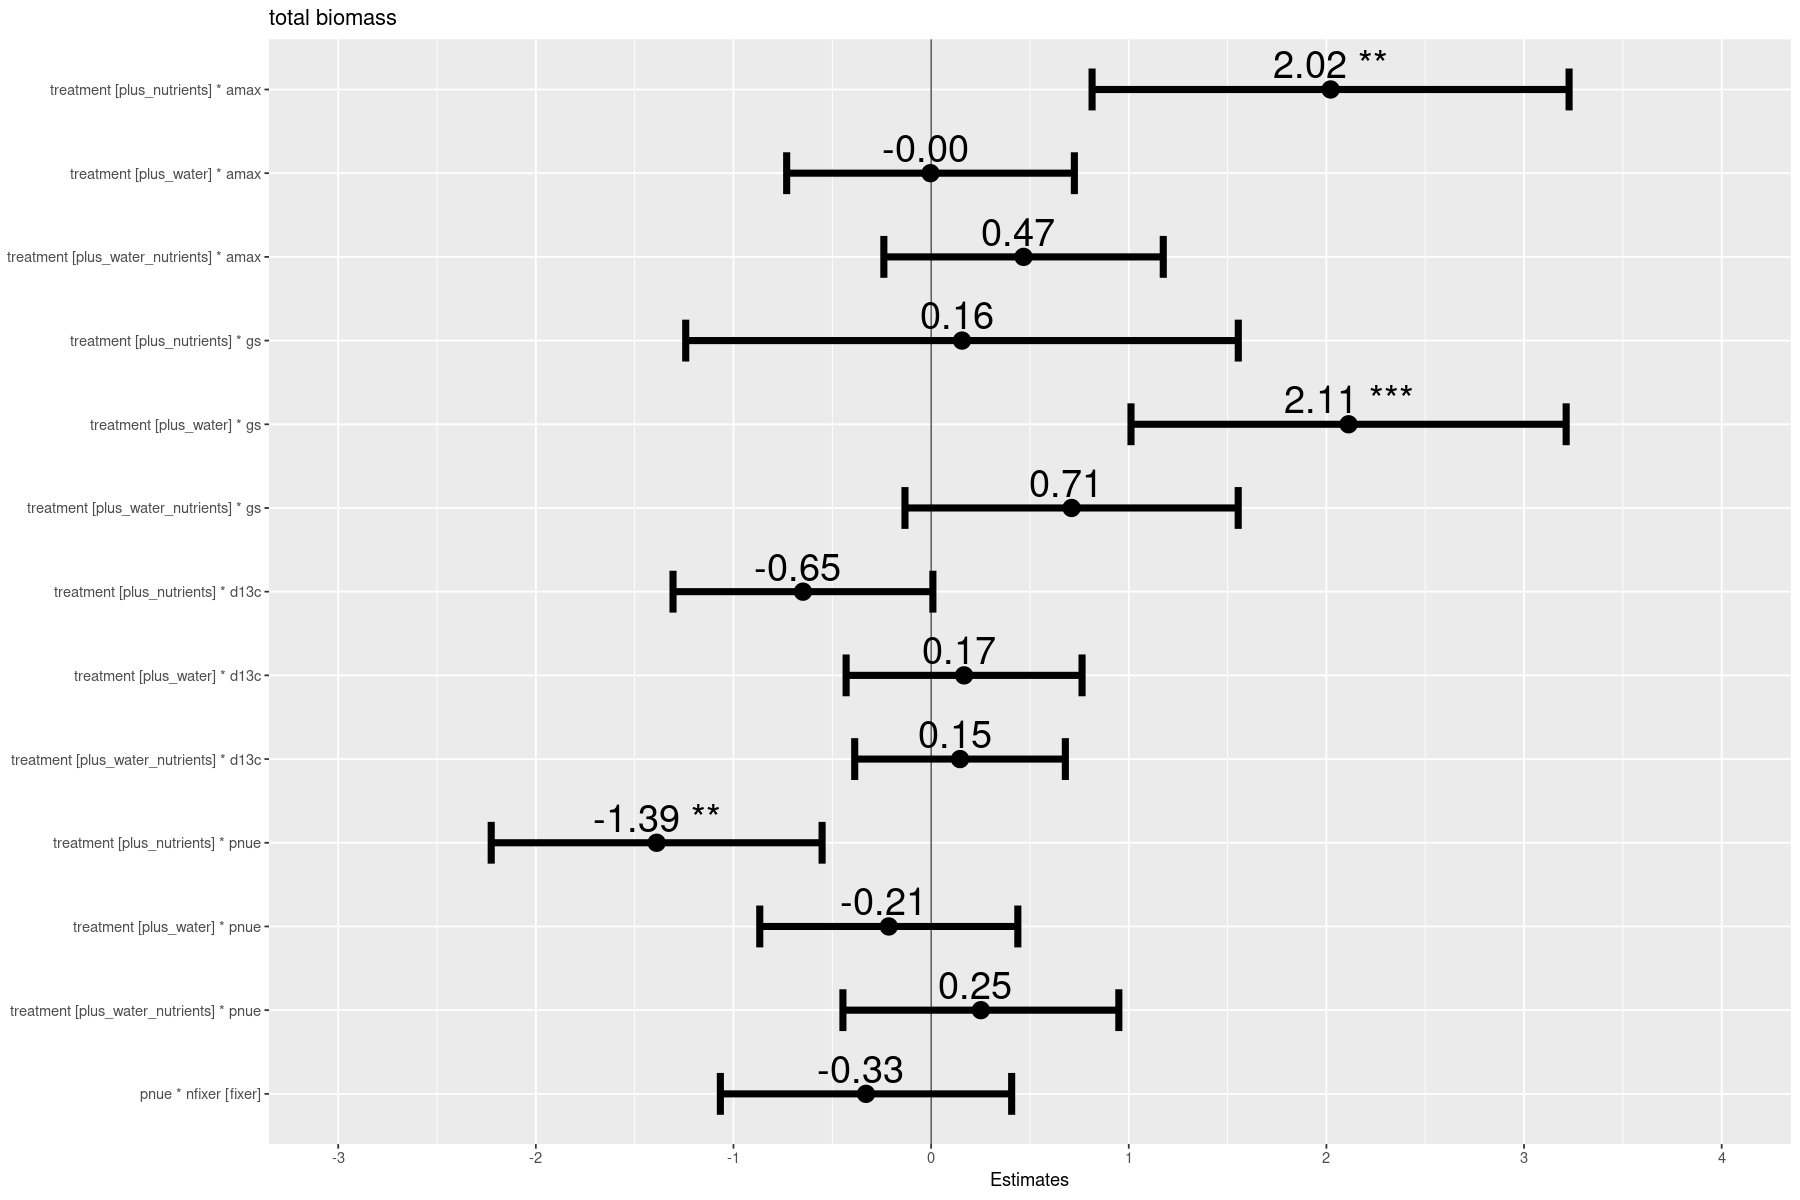

In [45]:
plot_model(model_pc_total_biomass, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "pnue", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "pnue:nfixerfixer"
                                    ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = TRUE,
                        )

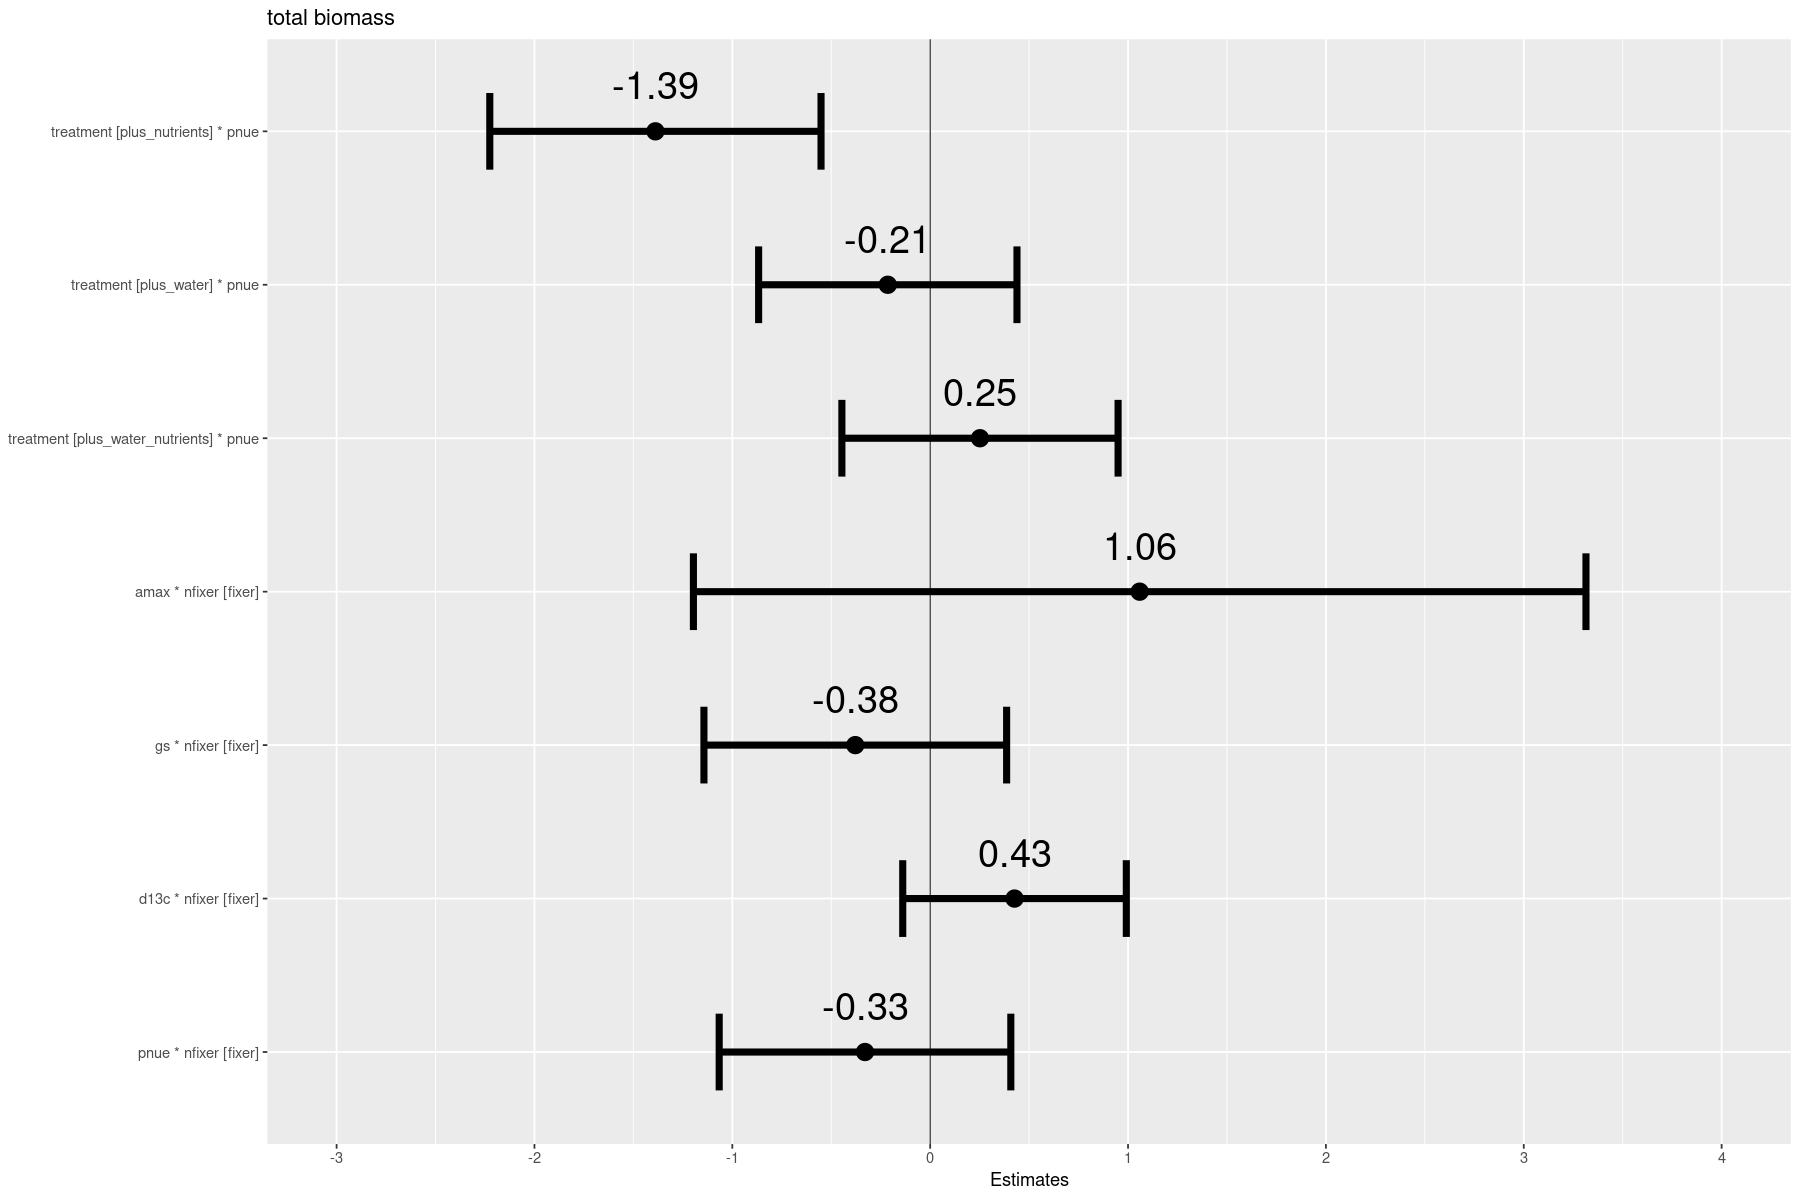

In [46]:
plot_model(model_pc_total_biomass, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "pnue", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",

                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:pnue",
                                     "treatmentplus_water:pnue",
                                     "treatmentplus_water_nutrients:pnue"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        )

### RGR 

In [47]:
Anova(model_pc_rgr, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),18.1702563,1,7.65737,3.041206e-03
treatment,35.3021286,3,404.26341,2.774815e-20
amax,1.3706176,1,406.70522,2.423913e-01
gs,3.8520922,1,403.71337,5.037030e-02
d13c,0.1331503,1,405.05248,7.153783e-01
pnue,1.0837630,1,405.08150,2.984782e-01
nfixer,5.5001171,1,6.63216,5.342763e-02
init_height,109.2871253,1,405.23449,8.308489e-23
treatment:amax,3.5452868,3,404.91523,1.468311e-02


#### Amax

In [48]:
emtrends(model_pc_rgr,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|  upper.CL|   t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|---------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -0.0008931| 0.0004534| 405.0045| -0.0020627| 0.0002765| -1.969886| 0.2011501|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             |  0.0002796| 0.0002730| 403.9750| -0.0004246| 0.0009839|  1.024294| 0.7353055|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.0003793| 0.0002663| 406.4248| -0.0010663| 0.0003076| -1.424509| 0.4847331|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  0.0011727| 0.0004497| 404.5281|  0.00

#### gs

In [49]:
emtrends(model_pc_rgr,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_nutrients)         | -0.0002824| 0.0005238| 403.3736| -0.0016337|  0.0010689| -0.5391635| 0.9493994|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water)             | -0.0014975| 0.0004133| 404.5924| -0.0025638| -0.0004313| -3.6231527| 0.0018570|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water_nutrients)   | -0.0003055| 0.0003163| 404.1022| -0.0011214|  0.0005103| -0.9660841| 0.7688126|
|(gs-0.00451570905042949 plus_nutrients) - (gs-0.00451570905042949 plus_water)           | -0.0012151| 0.0004986| 403.5317| -0.0025014|  0.0000

#### d13c

In [50]:
emtrends(model_pc_rgr,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         | -0.0002024| 0.0002467| 404.3998| -0.0008389| 0.0004340| -0.8204919| 0.8447707|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             | -0.0004663| 0.0002241| 404.6557| -0.0010444| 0.0001117| -2.0810759| 0.1610311|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   | -0.0001747| 0.0002000| 404.2958| -0.0006906| 0.0003412| -0.8735710| 0.8185436|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.0002639| 0.0002522| 403.0913| -0.0009146| 

#### PNUE

In [52]:
emtrends(model_pc_rgr,
        pairwise ~ pnue*treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                                                                              |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_nutrients         |  0.0004444| 0.0003141| 404.2186| -0.0003659| 0.0012546|  1.4147538| 0.4908200|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water             |  0.0003025| 0.0002457| 405.9219| -0.0003313| 0.0009363|  1.2312018| 0.6073531|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water_nutrients   |  0.0000620| 0.0002616| 403.5922| -0.0006129| 0.0007369|  0.2370277| 0.9953085|
|pnue0.00179582118045257 plus_nutrients - pnue0.00179582118045257 plus_water           | -0.0001419| 0.0003334| 405.2429| -0.0010021| 0.0007183| -0.4254710| 0

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


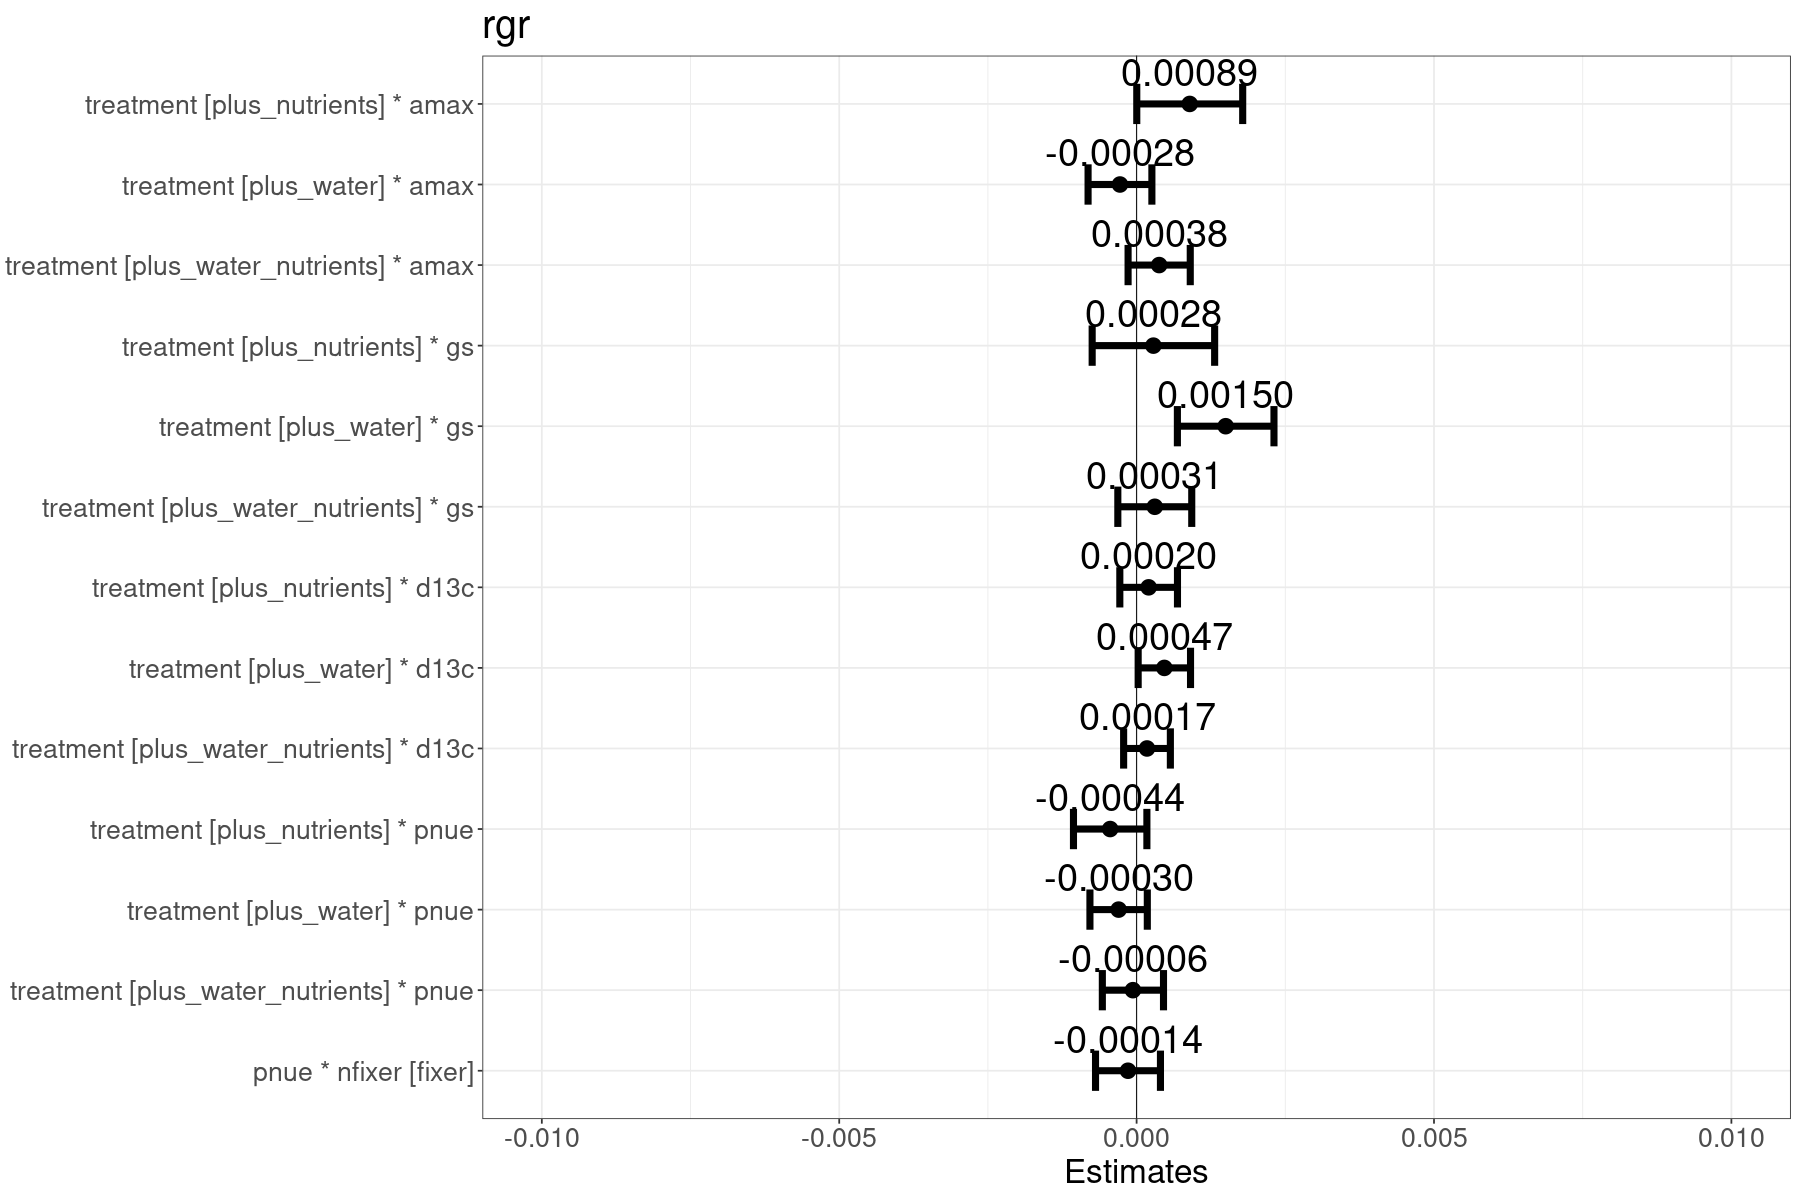

In [53]:
plot_model(model_pc_rgr, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "pnue", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "pnue:nfixerfixer"),
                        colors = "black",
                        value.offset = .4,
                        value.size = 8,
                        dot.size = 4,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,
                        digits = 5

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20)) +
                        ylim(-0.01,0.01)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


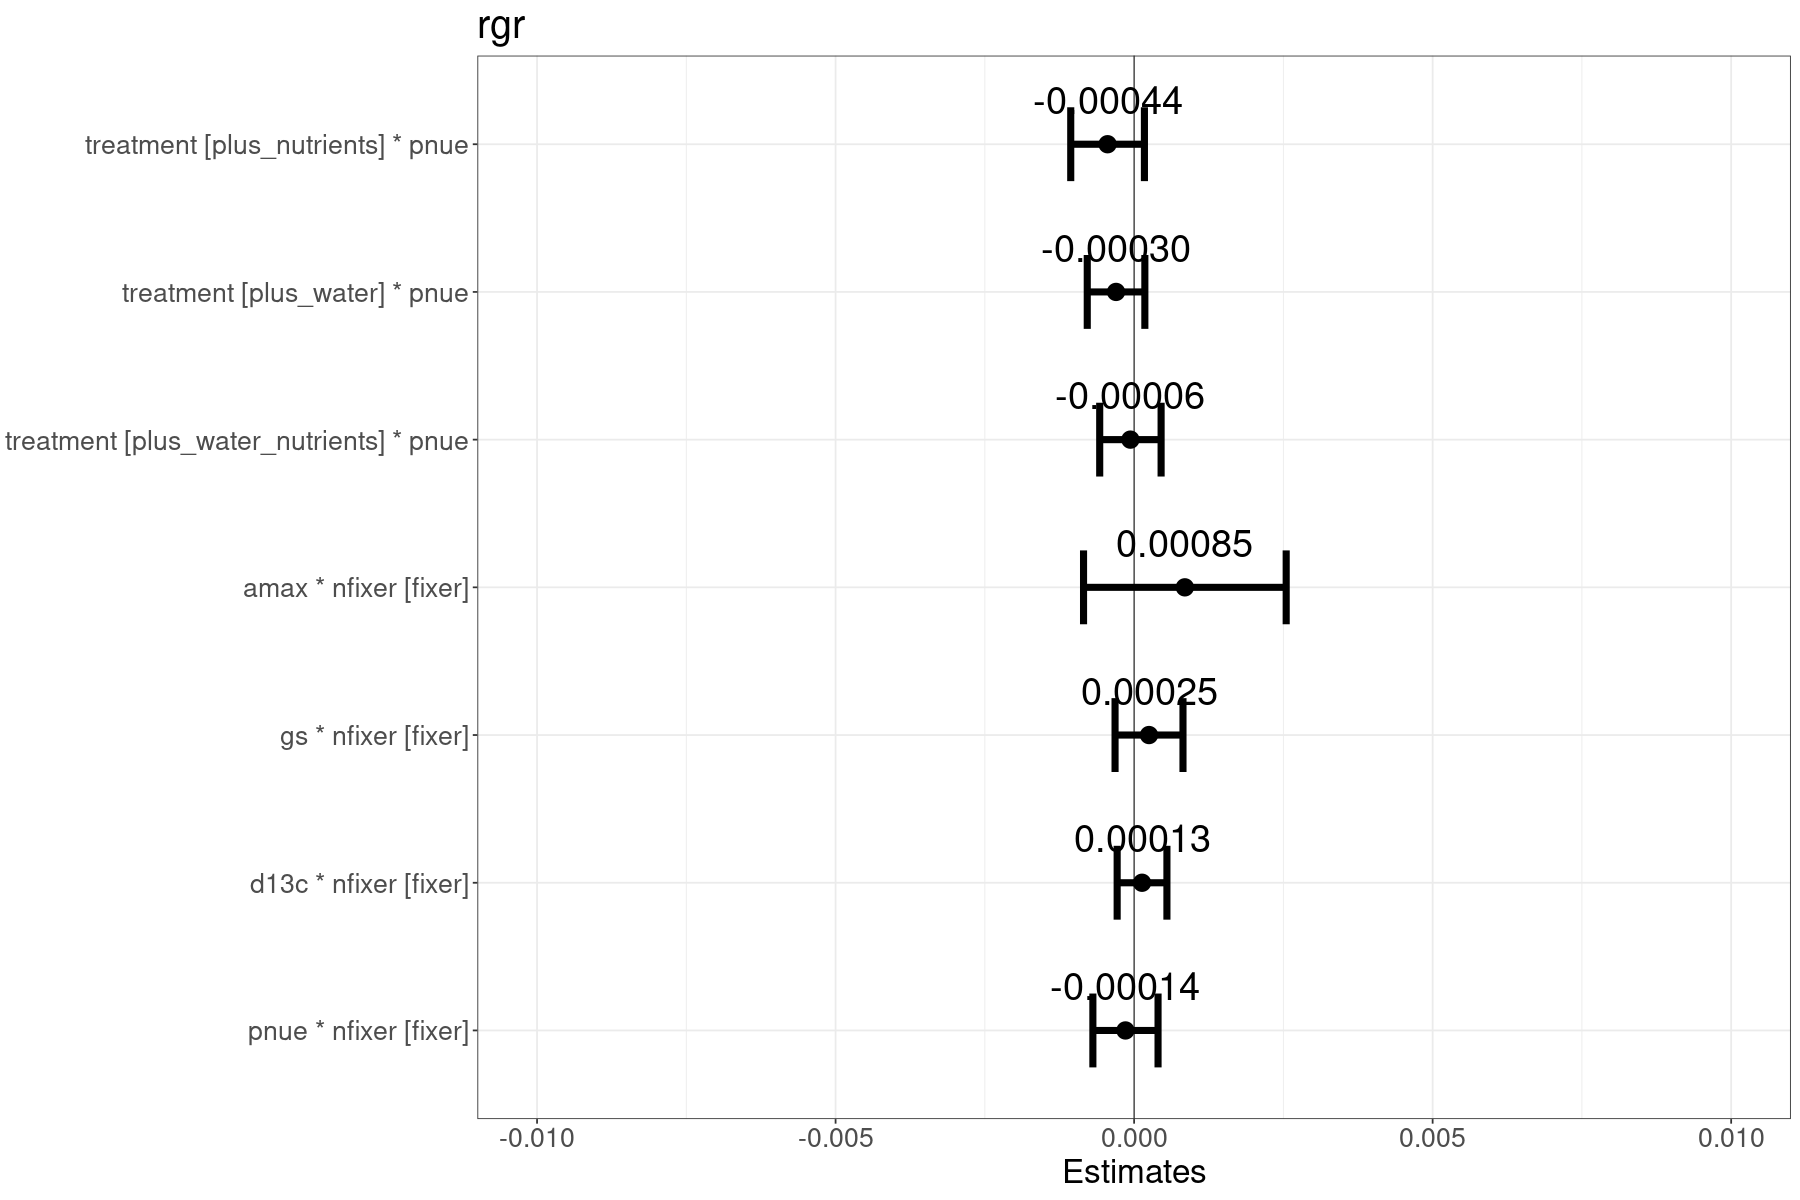

In [54]:
plot_model(model_pc_rgr, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "pnue", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",



                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:pnue",
                                     "treatmentplus_water:pnue",
                                     "treatmentplus_water_nutrients:pnue"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,
                        digits = 5

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20)) +
                        ylim(-0.01,0.01)

### Root to shoot ratio 

In [55]:
Anova(model_pc_root_shoot, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),13.70814749,1,7.019865,7.591816e-03
treatment,2.88310655,3,403.834236,3.561265e-02
amax,0.01115820,1,405.512043,9.159262e-01
gs,1.67443031,1,403.450617,1.964064e-01
d13c,0.91130179,1,404.351320,3.403396e-01
pnue,0.23526538,1,404.348971,6.279095e-01
nfixer,0.21452813,1,6.404849,6.585644e-01
init_height,0.30015179,1,408.900569,5.840862e-01
treatment:amax,13.60105767,3,404.290819,1.804196e-08


#### Amax

In [56]:
emtrends(model_pc_root_shoot,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|   upper.CL|   t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|---------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -0.4664135| 0.0864436| 404.3256| -0.6894161| -0.2434109| -5.395581| 0.0000007|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             | -0.2567512| 0.0520450| 403.6198| -0.3910150| -0.1224874| -4.933258| 0.0000070|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.1833433| 0.0507838| 405.3540| -0.3143512| -0.0523354| -3.610273| 0.0019463|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  0.2096623| 0.0857324| 404.0083| 

#### gs

In [57]:
emtrends(model_pc_root_shoot,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_nutrients)         |  0.2381908| 0.0998565| 403.2332| -0.0194165| 0.4957982|  2.3853313| 0.0815236|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water)             |  0.0800069| 0.0788026| 404.0372| -0.1232844| 0.2832982|  1.0152823| 0.7405894|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water_nutrients)   |  0.0564985| 0.0602926| 403.7013| -0.0990421| 0.2120391|  0.9370720| 0.7849117|
|(gs-0.00451570905042949 plus_nutrients) - (gs-0.00451570905042949 plus_water)           | -0.1581839| 0.0950545| 403.3417| -0.4034028| 0.0870350| -

#### d13c

In [58]:
emtrends(model_pc_root_shoot,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|   upper.CL|   t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|---------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         |  0.1770022| 0.0470366| 403.9193|  0.0556592|  0.2983452|  3.763073| 0.0011015|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             |  0.0879497| 0.0427247| 404.0994| -0.0222694|  0.1981688|  2.058521| 0.1686612|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   |  0.0093232| 0.0381254| 403.8519| -0.0890311|  0.1076775|  0.244540| 0.9948551|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.0890525| 0.0480842| 403.0563| -0.2130991| 

#### PNUE

In [59]:
emtrends(model_pc_root_shoot,
        pairwise ~ pnue*treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                                                                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_nutrients         |  0.1969485| 0.0598803| 403.7773|  0.0424715|  0.3514254|  3.2890349| 0.0059993|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water             |  0.0083926| 0.0468496| 404.9865| -0.1124666|  0.1292518|  0.1791397| 0.9979563|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water_nutrients   |  0.0174529| 0.0498758| 403.3815| -0.1112152|  0.1461210|  0.3499275| 0.9852749|
|pnue0.00179582118045257 plus_nutrients - pnue0.00179582118045257 plus_water           | -0.1885559| 0.0635804| 404.5045| -0.3525769| -0.0245348| -2.9656

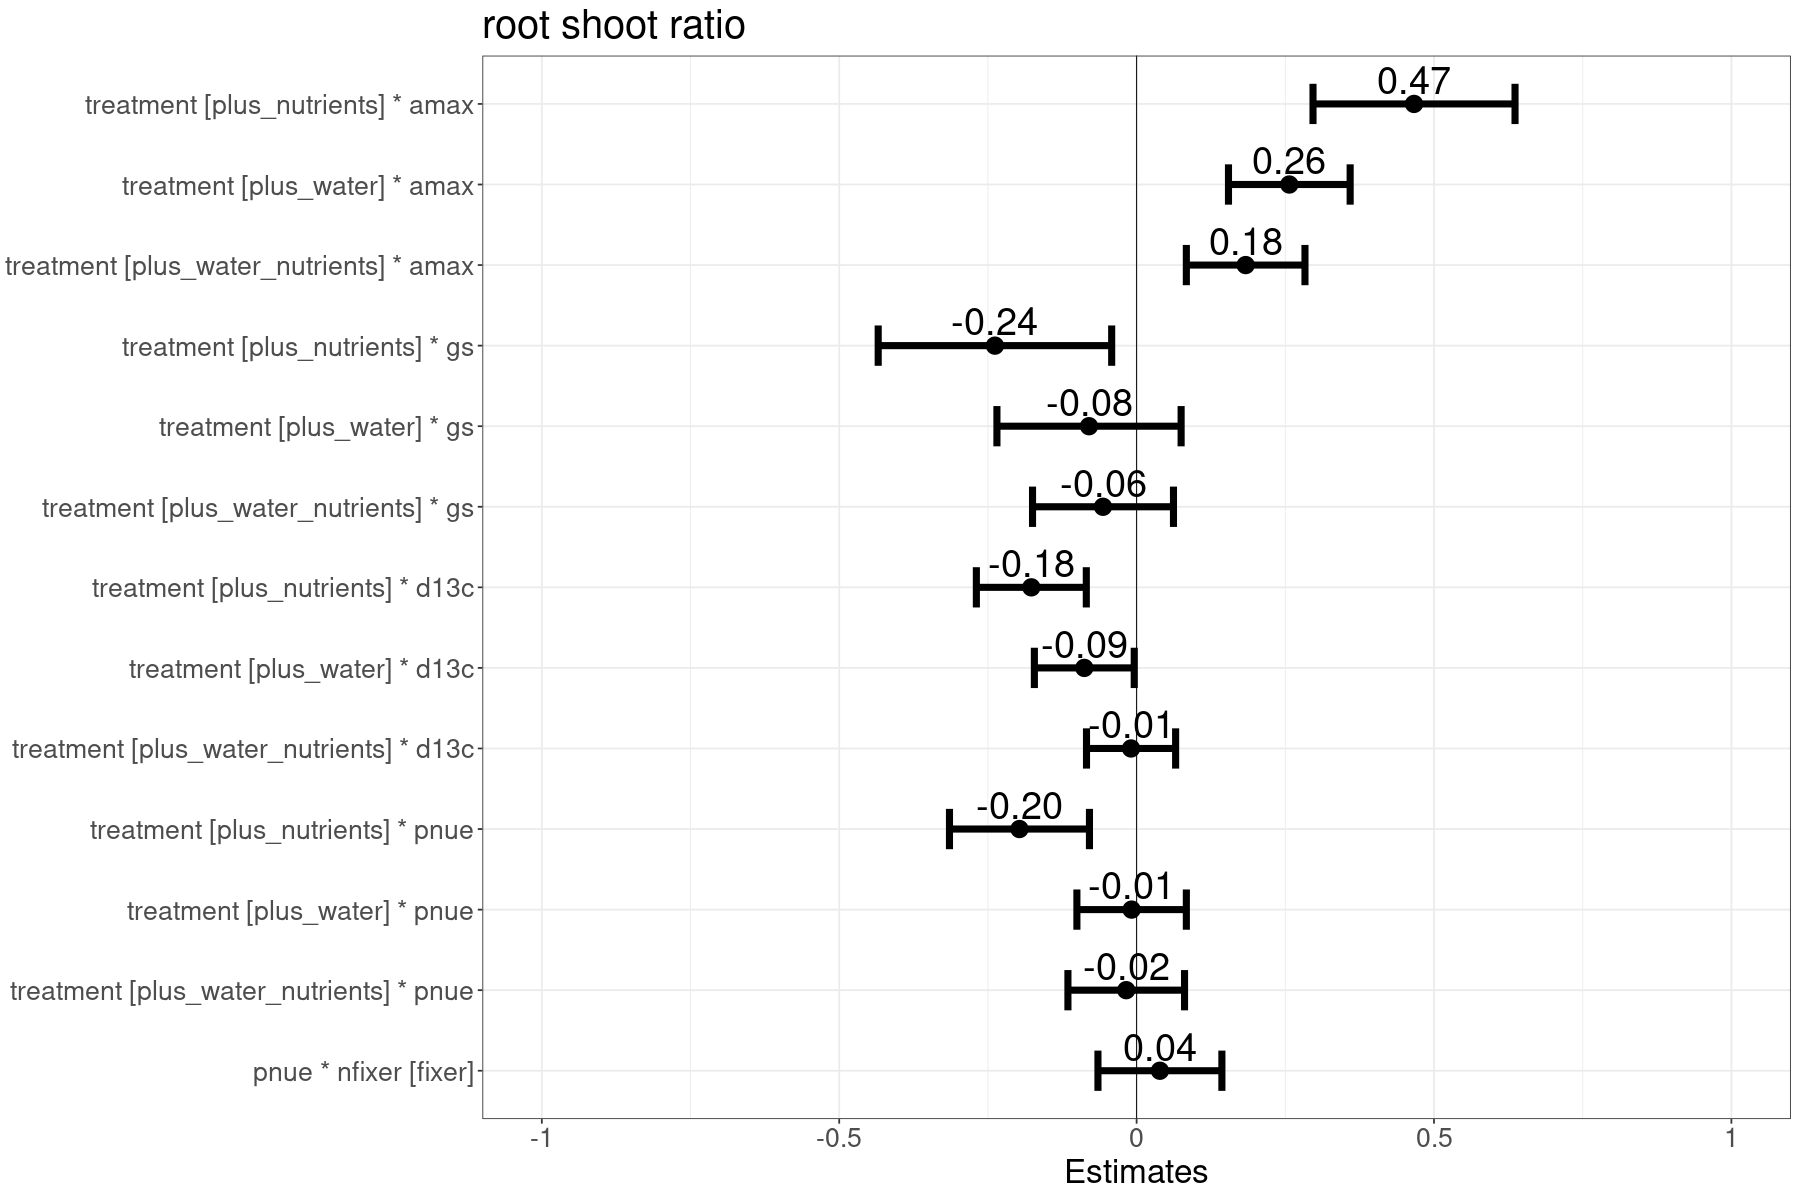

In [60]:
plot_model(model_pc_root_shoot, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "pnue", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "pnue:nfixerfixer"
                                    ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20))

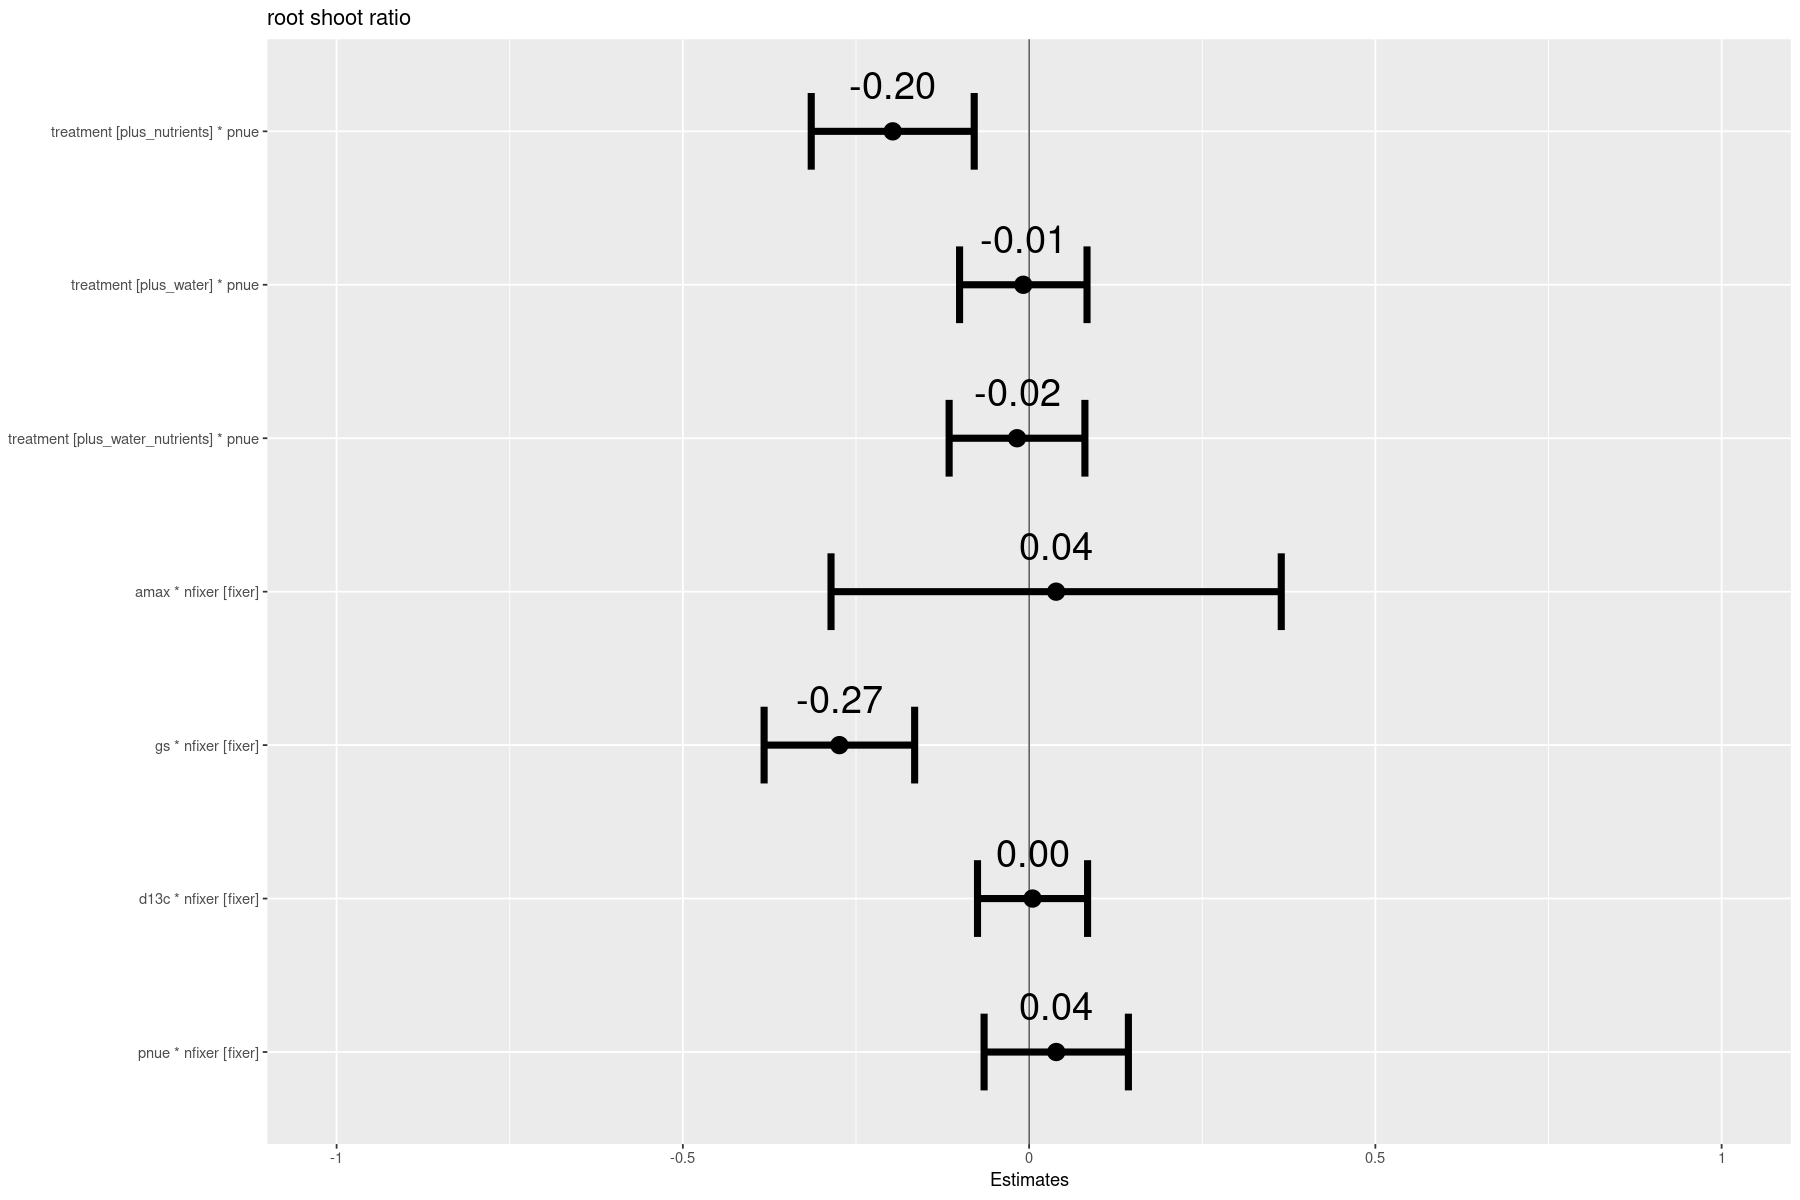

In [61]:
plot_model(model_pc_root_shoot, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "pnue", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",

                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:pnue",
                                     "treatmentplus_water:pnue",
                                     "treatmentplus_water_nutrients:pnue"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        )